# Summary of methods
Gene expression data were analyzed from the control samples originally used in Libbrecht _et al._ (2016) Current Biology 26:3 391-395 and Libbrecht _et al._ (2018) BMC Biology 16:89. Control samples in each case consist of age-matched workers in the Reproductive phase in the presence of pupae, or age-matched workers in the Brood Care phase with larvae. 

# Control samples used in analysis
The following table shows the NCBI SRA and BioSample IDs for the samples used for this analysis

| SRS ID | BioSample ID | Sample ID | Treatment Group |
|---|---|---|---|
| SRS844747 | SAMN03332204 | C.biroi_brains_11 | FL12 |
| SRS844745 | SAMN03332206 | C.biroi_brains_13 | FL12 |
| SRS844781 | SAMN03332216 | C.biroi_brains_23 | FL12 |
| SRS844749 | SAMN03332217 | C.biroi_brains_24 | FL12 |
| SRS844765 | SAMN03332229 | C.biroi_brains_36 | FL12 |
| SRS844752 | SAMN03332230 | C.biroi_brains_37 | FL12 |
| SRS844767 | SAMN03332231 | C.biroi_brains_38 | FL12 |
| SRS844736 | SAMN03332203 | C.biroi_brains_10 | SP12 |
| SRS844746 | SAMN03332205 | C.biroi_brains_12 | SP12 |
| SRS844750 | SAMN03332215 | C.biroi_brains_22 | SP12 |
| SRS844748 | SAMN03332227 | C.biroi_brains_34 | SP12 |
| SRS844766 | SAMN03332228 | C.biroi_brains_35 | SP12 |
| SRS844784 | SAMN03332240 | C.biroi_brains_47 | SP12 |
| SRS844751 | SAMN03332241 | C.biroi_brains_48 | SP12 |
| SRS1186132 | SAMN04308694 | C.biroi_brains_107 | STC6 |
| SRS1186135 | SAMN04308693 | C.biroi_brains_106 | STC6 |
| SRS1186133 | SAMN04308692 | C.biroi_brains_105 | STC1 |
| SRS1186134 | SAMN04308691 | C.biroi_brains_104 | STC1 |
| SRS1186136 | SAMN04308690 | C.biroi_brains_103 | C1 |
| SRS1186137 | SAMN04308689 | C.biroi_brains_102 | C1 |
| SRS1186138 | SAMN04308688 | C.biroi_brains_101 | C16 |
| SRS1186115 | SAMN04308687 | C.biroi_brains_100 | C16 |

# RNASeq analysis using DESeq 2
Gene expression values were determined using the method described in Chandra et al (2018) Science 361:6400, 398-402 [DOI: 10.1126/science.aar5723](https://doi.org/10.1126/science.aar5723). The following script was used to analyse the gene expression of the above samples.

```
# load DESeq2 library and functions:
library("DESeq2")

# set location of HTSeq count files:
htseq_dir <- "../htseq"

# extract sample files:
sampleFilesP <- grep("P.*(_SP|_FL).*htseq.gene.out", list.files(htseq_dir), value=TRUE)
sampleFilesM <- grep("M.*(_SP|_FL).*htseq.gene.out", list.files(htseq_dir), value=TRUE)
sampleFilesP
sampleFilesM

names <- c("P", "M") # for saving results of each loop consistently with HTSeq file names
i <- 0
for(sampleFiles in list(sampleFilesP, sampleFilesM)){

  i <- i+1
  sampleset <- names[i]
  
  # assign phase and batch to each sample, based on filename:
  sampleCondition <- sub(".*(_SP|_FL).*", "\\1", sampleFiles)
  
  sampleBatch <- sub("[PM]_(B[0-9]).*", "\\1", sampleFiles)
  
  # construct table, including design (incorporates batch effect in model)
  sampleTable <- data.frame(sampleName = sampleFiles,
                             fileName = sampleFiles,
                             condition = sampleCondition,
  			   batch = sampleBatch)
  print(sampleTable)
  
  ### PERFORM TESTS ###                          
  # standard
  dds <- DESeqDataSetFromHTSeqCount(sampleTable = sampleTable,
                                          directory = htseq_dir,
                                          design= ~ batch + condition)
  
  dds_std <- DESeq(dds, minReplicatesForReplace=5)
  
  # look at results of tests:
  resQF <- results(dds_std, alpha=0.05, contrast=c("condition", "_SP", "_FL"))
  
  # produce and save the variance adjusted count values for each gene and save to file:
  vsd <- varianceStabilizingTransformation(dds_std)
  vstMat <- assay(vsd)
  write.table(as.data.frame(vstMat), file=paste("../DESeqResults/Ooceraea.genes.all_samples", sampleset, "vst.tbl", sep = "."))
  
  # order results on adjusted pvalue:
  resQFOrdered <- resQF[order(resQF$padj),]
  print(head(resQFOrdered))
  print(summary(resQF))
  
  # count number of genes with adjusted pvalue less than 0.05
  SigQF <- subset(resQFOrdered, padj < 0.05)
  length(SigQF$padj)
  
  # graph all variance adjusted genes:
  plotMA(resQF, main="statary and foraging Ooceraea Samples (Genes)", ylim=c(-2,2))
  
  # save pvalue and log fold change results for all genes to file:
  write.table(as.data.frame(resQFOrdered), file=paste("../DESeqResults/Ooceraea.genes.all_samples", sampleset, "pvalues.out", sep = ".") )

}

```

# Visualization of gene expression

## Import required Python libraries

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

In [3]:
import re

## Define key variables

In [4]:
itc = 'LOC105274751'
itr = 'LOC105286925'

In [5]:
GENE_EXPRESSION_TABLE_1 = "../DESeqResults/Ooceraea.genes.all_samples.P.vst.tbl"
GENE_EXPRESSION_TABLE_2 = "../DESeqResults/Ooceraea.genes.all_samples.M.vst.tbl"
PVALUE_TABLE_1 = "../DESeqResults/Ooceraea.genes.all_samples.P.pvalues.out"
PVALUE_TABLE_2 = "../DESeqResults/Ooceraea.genes.all_samples.M.pvalues.out"

## Functions to extract relevant expression data from table

In [6]:
def parse_treatment(name):
    "extracts treatment type from filename"
    srch = re.search("_([FS][LP]\d+)", name)
    if srch:
        return srch.group(1)
    else:
        return None

In [7]:
def get_deseq_stats(pvalues, geneid, rename=None, saveto=None):
    """
    extract DESeq2 statistics for a given gene from DESeq2 output file
    
    pvalues: str
        name of DESeq2 output file
    geneid: str
        genename to extract
    rename: str or None
        string to rename the geneid in the output table. If None, uses geneid
    saveto: str
        filepath to save dataframe as csv
    """
    if not rename:
        rename=geneid
        
    df_pval = pd.read_csv(pvalues, delim_whitespace=True)
    df_pval = df_pval[df_pval.index == geneid].T.rename(columns={geneid:rename,})
    
    # Save gene's stats to file
    if saveto:
        df_pval.to_csv(saveto, index=False)

    return df_pval

In [8]:
def get_expression_data(gene_expression, geneid, rename=None, saveto=None):
    """
    extract DESeq2 VST expression data for a given gene
    
    gene_expression: str
        name of DESeq2 VST expression file (other expression files would likely work to)
    geneid: str
        genename to extract
    rename: str or None
        string to rename the geneid in the output table. If None, uses geneid
    saveto: str
        filepath to save dataframe as csv
    """
    df_vst = pd.read_csv(gene_expression, delim_whitespace=True)
    
    if not rename:
        rename=geneid
    
    df_gene = df_vst[df_vst.index==geneid].T.reset_index().rename(columns={geneid:rename, 'index':'sample'})
    df_gene['treatment'] = df_gene['sample'].apply(parse_treatment)
    
    phase_names = {"F":"Brood Care", "S":"Reproductive"}
    df_gene['phase'] = df_gene.treatment.apply(lambda x: phase_names[x[0]])
    
    # Save gene's expression data to file
    if saveto:
        df_gene.to_csv(saveto, index=False)

    return df_gene.sort_values('phase', ascending=False)
    

In [9]:
def plot_gene(df_expression, df_stats, geneid, title_qualifer, saveto=None ):
    """
    plots gene expression and prints stats for given gene.
    """
    fig, ax = plt.subplots(figsize=(8,8))
    sns.boxplot(data=df_expression, x='phase', y=geneid, ax=ax, color='w', width=0.4)
    sns.swarmplot(data=df_expression, x='phase', y=geneid, ax=ax, size=10)

    # set plot labels
    pval = df_stats.loc['pvalue',geneid]
    padj = df_stats.loc['padj',geneid]
    plt.title(f"Gene expression for {geneid} {title_qualifer}\nP={pval:.2f} (FDR={padj:.2f})", fontsize=18)
    plt.ylabel("Variance Stabilized Transformed (VST) Gene Expression", fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Phase", fontsize=14)
    plt.xticks(fontsize=14)
    
    if saveto:
        plt.savefig(saveto)
    
    plt.show()

# Extract and plot data

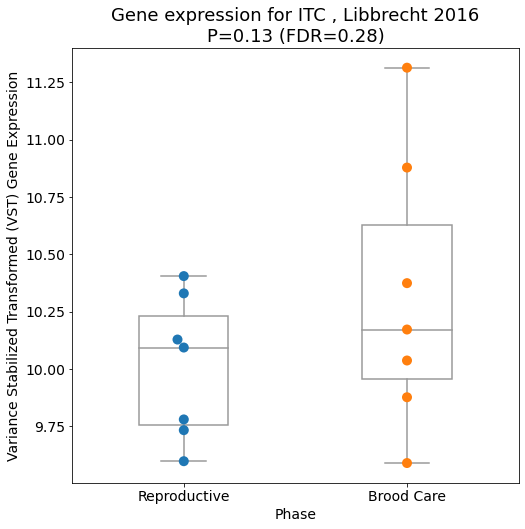

In [10]:
expression_data = GENE_EXPRESSION_TABLE_1
stats_table = PVALUE_TABLE_1
gene = itc
genelabel = "ITC"
experiment_no = 2016

basename = f"../{genelabel}_experiment_{experiment_no}"
df_expr = get_expression_data(expression_data, gene, genelabel, saveto=f"{basename}.csv")
df_stats = get_deseq_stats(stats_table, gene, genelabel)
plot_gene(df_expr, df_stats, genelabel, f", Libbrecht {experiment_no}", saveto=f"{basename}.svg")

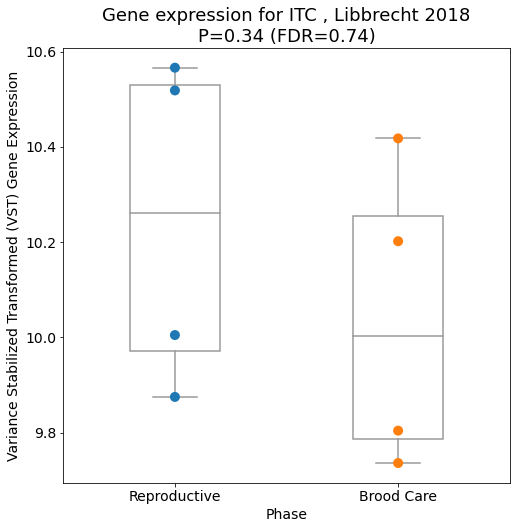

In [11]:
expression_data = GENE_EXPRESSION_TABLE_2
stats_table = PVALUE_TABLE_2
gene = itc
genelabel = "ITC"
experiment_no = 2018

basename = f"../{genelabel}_experiment_{experiment_no}"
df_expr = get_expression_data(expression_data, gene, genelabel, saveto=f"{basename}.csv")
df_stats = get_deseq_stats(stats_table, gene, genelabel)
plot_gene(df_expr, df_stats, genelabel, f", Libbrecht {experiment_no}", saveto=f"{basename}.svg")

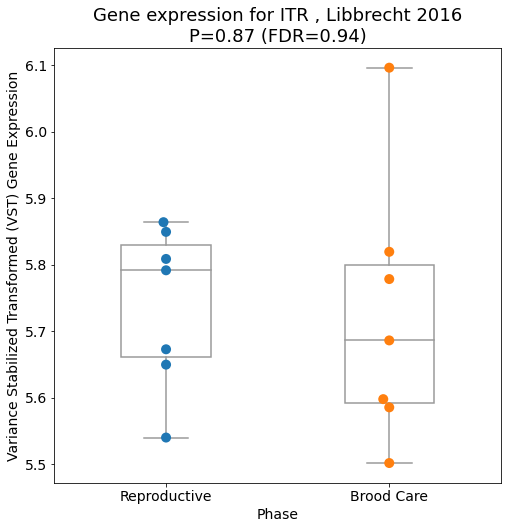

In [12]:
expression_data = GENE_EXPRESSION_TABLE_1
stats_table = PVALUE_TABLE_1
gene = itr
genelabel = "ITR"
experiment_no = 2016

basename = f"../{genelabel}_experiment_{experiment_no}"
df_expr = get_expression_data(expression_data, gene, genelabel, saveto=f"{basename}.csv")
df_stats = get_deseq_stats(stats_table, gene, genelabel)
plot_gene(df_expr, df_stats, genelabel, f", Libbrecht {experiment_no}", saveto=f"{basename}.svg")

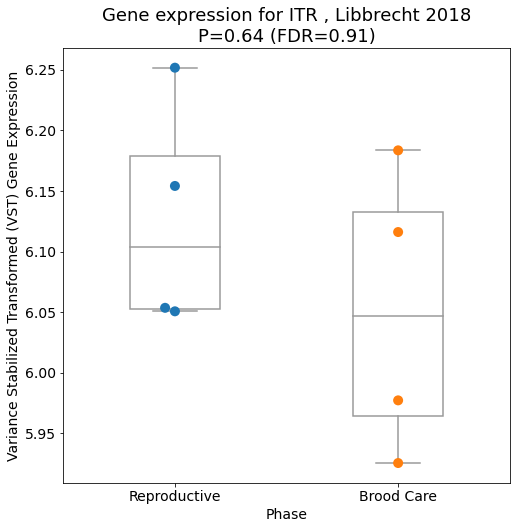

In [13]:
expression_data = GENE_EXPRESSION_TABLE_2
stats_table = PVALUE_TABLE_2
gene = itr
genelabel = "ITR"
experiment_no = 2018

basename = f"../{genelabel}_experiment_{experiment_no}"
df_expr = get_expression_data(expression_data, gene, genelabel, saveto=f"{basename}.csv")
df_stats = get_deseq_stats(stats_table, gene, genelabel)
plot_gene(df_expr, df_stats, genelabel, f", Libbrecht {experiment_no}", saveto=f"{basename}.svg")

In [14]:
pd.__version__

'1.0.3'

In [15]:
sns.__version__

'0.11.0'

In [16]:
import matplotlib
matplotlib.__version__

'3.2.1'